# Load data & packages

In [ ]:
import os
print("Files in current directory:", os.listdir('.'))

Files in current directory: ['.config', 'transit_data.xlsx', 'sample_data']


In [ ]:
!pip install pregress

In [ ]:
import pandas as pd
import pregress as pr
import matplotlib.pyplot as plt

# Clean data

In [ ]:
FILE = '/content/transit_data.xlsx'

# 1. Load DataFrames
routes = pd.read_excel(FILE, sheet_name="routes", engine="openpyxl")
trips = pd.read_excel(FILE, sheet_name="trips", engine="openpyxl")
stop_times = pd.read_excel(FILE, sheet_name="stop_times", engine="openpyxl")
stops = pd.read_excel(FILE, sheet_name="stops", engine="openpyxl")
calendar = pd.read_excel(FILE, sheet_name="calendar", engine="openpyxl")
shapes = pd.read_excel(FILE, sheet_name="shapes", engine="openpyxl")
calendar_dates = pd.read_excel(FILE, sheet_name="calendar_dates", engine="openpyxl")

print("DataFrames loaded.")

# 2. Drop columns with high missingness
# From routes
print(f"\nOriginal routes shape: {routes.shape}")
routes = routes.drop(columns=['agency_id', 'route_url', 'route_desc', 'route_text_color'], errors='ignore')
print(f"New routes shape after dropping columns: {routes.shape}")

# From trips
print(f"\nOriginal trips shape: {trips.shape}")
trips = trips.drop(columns=['trip_short_name'], errors='ignore')
print(f"New trips shape after dropping columns: {trips.shape}")

# From stops
print(f"\nOriginal stops shape: {stops.shape}")
stops = stops.drop(columns=['location_type', 'parent_station', 'zone_id', 'stop_url', 'stop_timezone', 'stop_desc'], errors='ignore')
print(f"New stops shape after dropping columns: {stops.shape}")

# 3. Handle critical missing values
# From stop_times
print(f"\nOriginal stop_times shape: {stop_times.shape}")
stop_times = stop_times.dropna(subset=['arrival_time', 'departure_time'])
print(f"New stop_times shape after dropping rows with missing times: {stop_times.shape}")

DataFrames loaded.

Original routes shape: (129, 9)
New routes shape after dropping columns: (129, 5)

Original trips shape: (24529, 10)
New trips shape after dropping columns: (24529, 9)

Original stops shape: (6530, 12)
New stops shape after dropping columns: (6530, 6)

Original stop_times shape: (943398, 10)
New stop_times shape after dropping rows with missing times: (915561, 10)


In [ ]:
def check_cleaning(name, df):
    if df is None:
        print(f"--- {name} not found in memory ---")
        return
    print(f"--- Cleaning Check: {name} ---")
    # 1. Duplicates
    dupes = df.duplicated().sum()
    print(f"Duplicate rows: {dupes}")

    # 2. Column-specific logic
    if name == 'stop_times':
        invalid_seq = (df['stop_sequence'] < 0).sum()
        print(f"Negative stop_sequences: {invalid_seq}")

    if name == 'trips' and 'routes' in globals():
        orphans = (~df['route_id'].isin(routes['route_id'])).sum()
        print(f"Trips with missing route_id in routes table: {orphans}")

# Run checks on variables verified in previous cells
check_cleaning('routes', routes if 'routes' in globals() else None)
check_cleaning('trips', trips if 'trips' in globals() else None)
check_cleaning('stop_times', stop_times if 'stop_times' in globals() else None)
check_cleaning('stops', stops if 'stops' in globals() else None)

# Check for time format consistency
if 'stop_times' in globals() and 'arrival_time' in stop_times.columns:
    time_pattern = r'^\d{1,2}:\d{2}:\d{2}$'
    invalid_times = (~stop_times['arrival_time'].dropna().astype(str).str.match(time_pattern)).sum()
    print(f"\nArrival times not matching HH:MM:SS format: {invalid_times}")

--- Cleaning Check: routes ---
Duplicate rows: 0
--- Cleaning Check: trips ---
Duplicate rows: 0
Trips with missing route_id in routes table: 0
--- Cleaning Check: stop_times ---
Duplicate rows: 0
Negative stop_sequences: 0
--- Cleaning Check: stops ---
Duplicate rows: 0

Arrival times not matching HH:MM:SS format: 0


In [ ]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,4828771,05:32:00,05:32:00,795,1,NaN,0,0,NaN,1
1,4828771,05:33:00,05:33:00,796,2,NaN,0,0,0.5206,1
2,4828771,05:34:00,05:34:00,797,3,NaN,0,0,1.1206,1
3,4828771,05:35:00,05:35:00,798,4,NaN,0,0,1.4817,1
4,4828771,05:36:00,05:36:00,799,5,NaN,0,0,1.7449,1


# EDA (visualizations)

**Top 10 routes**

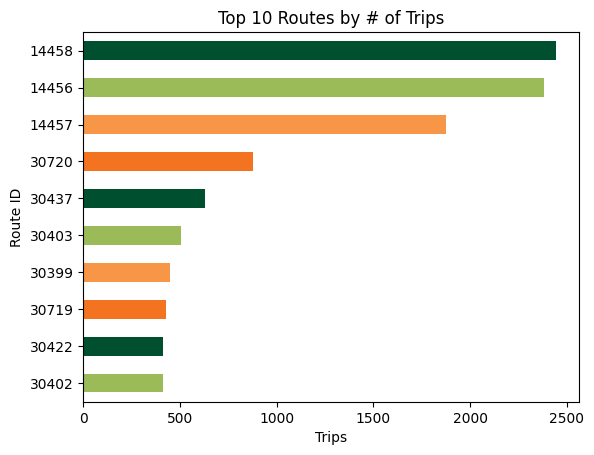

In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646']
top10 = trips["route_id"].value_counts().head(10)
top10.sort_values().plot(kind="barh", color=new_colors)

plt.title("Top 10 Routes by # of Trips")
plt.ylabel("Route ID")
plt.xlabel("Trips")
plt.show()

**Stops per Trip**

In [ ]:
stops_per_trip = stop_times.groupby("trip_id").size()

print(stops_per_trip.head())
print("Mean:", stops_per_trip.mean())
print("Median:", stops_per_trip.median())
print("Min:", stops_per_trip.min())
print("Max:", stops_per_trip.max())
print("90th percentile:", stops_per_trip.quantile(0.90))

trip_id
4745075    29
4745076    29
4745077    29
4745078    29
4745079    29
dtype: int64
Mean: 38.644310315718386
Median: 29.0
Min: 1
Max: 143
90th percentile: 84.0



=== Basic counts ===
     table   rows  unique_route_id  unique_trip_id  unique_service_id  unique_stop_id
    routes    129            129.0             NaN                NaN             NaN
     trips  24529            128.0         24529.0               12.0             NaN
  calendar     12              NaN             NaN               12.0             NaN
stop_times 943398              NaN         24529.0                NaN          6530.0

=== Missingness: routes (top 10) ===
                  missing  missing_%
agency_id             129     100.00
route_url             129     100.00
route_desc            129     100.00
route_text_color       77      59.69
route_id                0       0.00
route_long_name         0       0.00
route_short_name        0       0.00
route_type              0       0.00
route_color             0       0.00

=== Missingness: trips (top 10) ===
                       missing  missing_%
trip_short_name          24529      100.0
route_id           

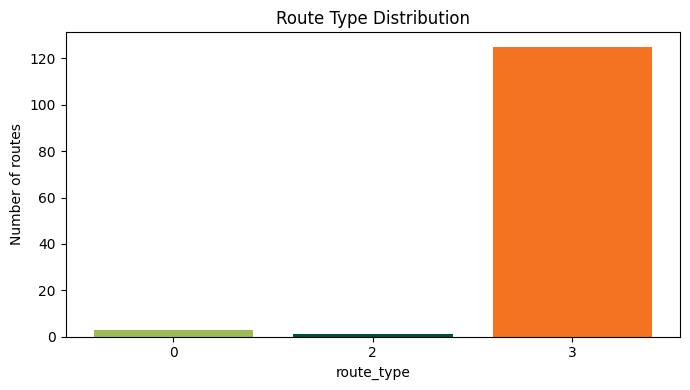


=== Top 10 routes by trips ===
 route_id  num_trips label
    30402        412     9
    30422        414    52
    30719        426    77
    30399        448     3
    30403        506    11
    30437        628   100
    30720        876  2600
    14457       1877   MMI
    14456       2384   MMO
    14458       2442   MIA


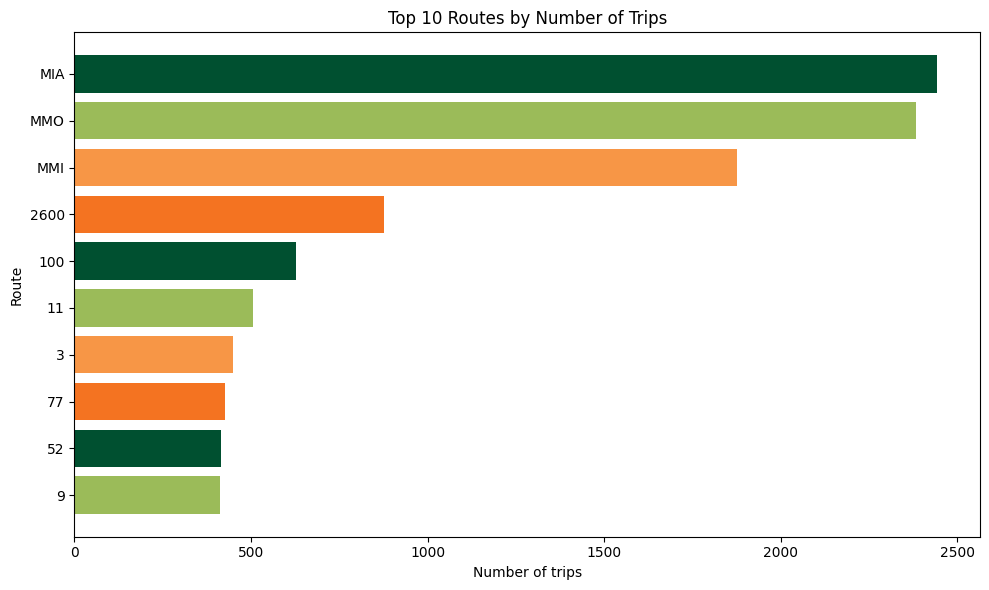


=== direction_id distribution ===
direction_id
0    12910
1    11619


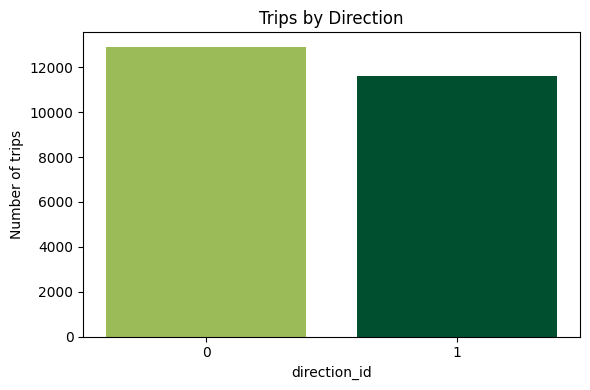


=== Calendar summary (first 12 rows) ===
 service_id  days_active_per_week start_date end_date  service_days_span
         19                     1        NaT      NaT                NaN
         18                     1        NaT      NaT                NaN
         21                     5        NaT      NaT                NaN
         13                     1        NaT      NaT                NaN
         11                     5        NaT      NaT                NaN
         12                     1        NaT      NaT                NaN
          8                     1        NaT      NaT                NaN
          7                     1        NaT      NaT                NaN
          6                     5        NaT      NaT                NaN
          3                     1        NaT      NaT                NaN
          1                     5        NaT      NaT                NaN
          2                     1        NaT      NaT                NaN


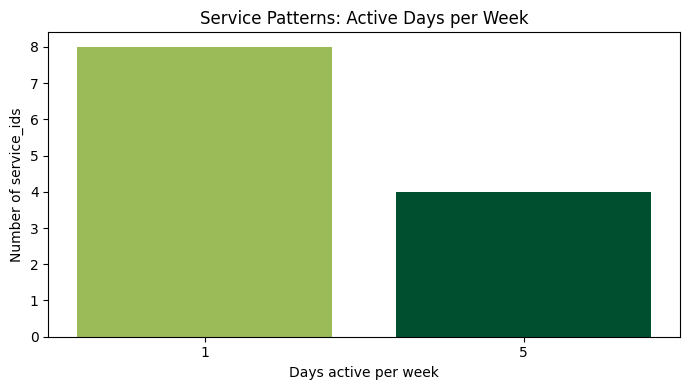


=== Stops per trip summary ===
Trips counted: 24529
Mean: 38.46
Median: 28.00
Min: 2
Max: 143
90th percentile: 84.00


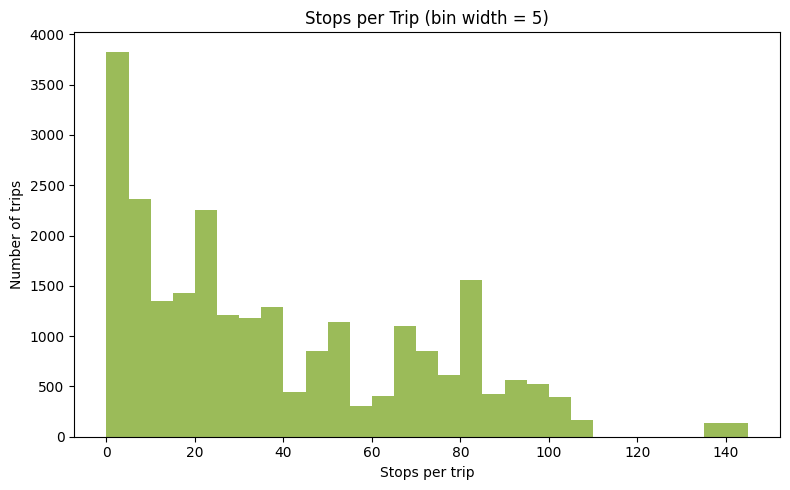


=== Trip duration (minutes) summary ===
Trips with duration computed: 23692
Mean: 45.58
Median: 42.00
Min: 0.00
Max: 164.00
90th percentile: 93.00


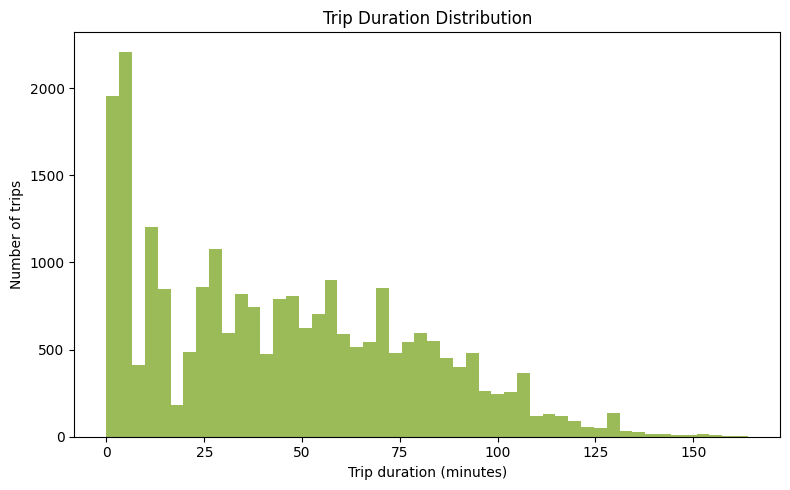


Saved: eda_basic_counts.csv, eda_top10_routes_by_trips.csv, eda_stops_per_trip.csv, eda_trip_duration_minutes.csv


In [ ]:
import pandas as pd
import pregress as pr
import matplotlib.pyplot as plt
import numpy as np # Add numpy import for np.nan

new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Define new_colors here

# -----------------------------
# Helpers
# -----------------------------
def parse_gtfs_time_to_seconds(s: pd.Series) -> pd.Series:
    """
    GTFS times can exceed 24:00:00 (e.g., 25:10:00). Convert to seconds.
    Returns float seconds (NaN if missing/invalid).
    """
    s = s.astype("string")
    parts = s.str.split(":", expand=True)
    if parts.shape[1] < 3:
        return pd.to_numeric(pd.Series([np.nan] * len(s)), errors="coerce")

    h = pd.to_numeric(parts[0], errors="coerce")
    m = pd.to_numeric(parts[1], errors="coerce")
    sec = pd.to_numeric(parts[2], errors="coerce")
    return h * 3600 + m * 60 + sec

def missing_table(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum()
    pct = (miss / len(df) * 100).round(2)
    out = pd.DataFrame({"missing": miss, "missing_%": pct}).sort_values("missing", ascending=False)
    return out

# -----------------------------
# Load sheets (use only needed columns where possible)
# -----------------------------
routes = pd.read_excel(FILE, sheet_name="routes", engine="openpyxl")
trips = pd.read_excel(FILE, sheet_name="trips", engine="openpyxl")
calendar = pd.read_excel(FILE, sheet_name="calendar", engine="openpyxl")

# stop_times is big; load only needed cols for core EDA
stop_times_cols = ["trip_id", "stop_id", "stop_sequence", "arrival_time", "departure_time"]
stop_times = pd.read_excel(FILE, sheet_name="stop_times", engine="openpyxl", usecols=stop_times_cols)

# -----------------------------
# 1) Basic counts table (most important)
# -----------------------------
counts = pd.DataFrame([
    {"table": "routes", "rows": len(routes),
     "unique_route_id": routes["route_id"].nunique() if "route_id" in routes else np.nan},
    {"table": "trips", "rows": len(trips),
     "unique_trip_id": trips["trip_id"].nunique() if "trip_id" in trips else np.nan,
     "unique_route_id": trips["route_id"].nunique() if "route_id" in trips else np.nan,
     "unique_service_id": trips["service_id"].nunique() if "service_id" in trips else np.nan},
    {"table": "calendar", "rows": len(calendar),
     "unique_service_id": calendar["service_id"].nunique() if "service_id" in calendar else np.nan},
    {"table": "stop_times", "rows": len(stop_times),
     "unique_trip_id": stop_times["trip_id"].nunique() if "trip_id" in stop_times else np.nan,
     "unique_stop_id": stop_times["stop_id"].nunique() if "stop_id" in stop_times else np.nan},
])
print("\n=== Basic counts ===")
print(counts.to_string(index=False))

# -----------------------------
# 2) Missingness (quick data quality)
# -----------------------------
print("\n=== Missingness: routes (top 10) ===")
print(missing_table(routes).head(10).to_string())

print("\n=== Missingness: trips (top 10) ===")
print(missing_table(trips).head(10).to_string())

print("\n=== Missingness: calendar ===")
print(missing_table(calendar).to_string())

print("\n=== Missingness: stop_times (top 10) ===")
print(missing_table(stop_times).head(10).to_string())

# -----------------------------
# 3) Route types distribution (routes)
# -----------------------------
if "route_type" in routes.columns:
    rt = routes["route_type"].value_counts().sort_index()
    print("\n=== route_type distribution ===")
    print(rt.to_string())

    plt.figure(figsize=(7, 4))
    plt.bar(rt.index.astype(str), rt.values, color=new_colors)
    plt.title("Route Type Distribution")
    plt.xlabel("route_type")
    plt.ylabel("Number of routes")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) Top 10 routes by number of trips (trips -> route_id)
# -----------------------------
top10 = trips["route_id"].value_counts().head(10).rename_axis("route_id").reset_index(name="num_trips")

# Optional: merge names if present
label = top10["route_id"].astype(str)
if "route_short_name" in routes.columns:
    tmp = routes[["route_id", "route_short_name"]].drop_duplicates()
    top10 = top10.merge(tmp, on="route_id", how="left")
    label = top10["route_short_name"].fillna(top10["route_id"].astype(str)).astype(str)
elif "route_long_name" in routes.columns:
    tmp = routes[["route_id", "route_long_name"]].drop_duplicates()
    top10 = top10.merge(tmp, on="route_id", how="left")
    label = top10["route_long_name"].fillna(top10["route_id"].astype(str)).astype(str)

plot_df = top10.copy()
plot_df["label"] = label
plot_df = plot_df.sort_values("num_trips", ascending=True)

print("\n=== Top 10 routes by trips ===")
print(plot_df[["route_id", "num_trips", "label"]].to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(plot_df["label"], plot_df["num_trips"], color=new_colors)
plt.title("Top 10 Routes by Number of Trips")
plt.xlabel("Number of trips")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

# -----------------------------
# 5) Direction split (trips)
# -----------------------------
if "direction_id" in trips.columns:
    d = trips["direction_id"].value_counts().sort_index()
    print("\n=== direction_id distribution ===")
    print(d.to_string())

    plt.figure(figsize=(6, 4))
    plt.bar(d.index.astype(str), d.values, color=new_colors)
    plt.title("Trips by Direction")
    plt.xlabel("direction_id")
    plt.ylabel("Number of trips")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 6) Calendar service patterns (calendar)
# -----------------------------
day_cols = [c for c in ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"] if c in calendar.columns]
if day_cols:
    cal = calendar.copy()
    cal["days_active_per_week"] = cal[day_cols].sum(axis=1)
    if "start_date" in cal.columns and "end_date" in cal.columns:
        cal["start_date"] = pd.to_datetime(cal["start_date"].astype(str), format="%Y%m%d", errors="coerce")
        cal["end_date"] = pd.to_datetime(cal["end_date"].astype(str), format="%Y%m%d", errors="coerce")
        cal["service_days_span"] = (cal["end_date"] - cal["start_date"]).dt.days

    print("\n=== Calendar summary (first 12 rows) ===")
    show_cols = ["service_id", "days_active_per_week"] + [c for c in ["start_date","end_date","service_days_span"] if c in cal.columns]
    print(cal[show_cols].to_string(index=False))

    plt.figure(figsize=(7, 4))
    vc = cal["days_active_per_week"].value_counts().sort_index()
    plt.bar(vc.index.astype(str), vc.values, color=new_colors)
    plt.title("Service Patterns: Active Days per Week")
    plt.xlabel("Days active per week")
    plt.ylabel("Number of service_ids")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7) Stops per trip (stop_times)
# -----------------------------
stops_per_trip = stop_times.groupby("trip_id").size()
print("\n=== Stops per trip summary ===")
print(f"Trips counted: {len(stops_per_trip)}")
print(f"Mean: {stops_per_trip.mean():.2f}")
print(f"Median: {stops_per_trip.median():.2f}")
print(f"Min: {stops_per_trip.min()}")
print(f"Max: {stops_per_trip.max()}")
print(f"90th percentile: {stops_per_trip.quantile(0.90):.2f}")

plt.figure(figsize=(8, 5))
# Bin width of 5 usually looks much better than defaults
bins = range(0, int(stops_per_trip.max()) + 6, 5)
plt.hist(stops_per_trip, bins=bins, color=new_colors[0])
plt.title("Stops per Trip (bin width = 5)")
plt.xlabel("Stops per trip")
plt.ylabel("Number of trips")
plt.tight_layout()
plt.show()

# -----------------------------
# 8) Trip duration (approx) from stop_times
#    duration = last departure - first arrival per trip
# -----------------------------
arr_sec = parse_gtfs_time_to_seconds(stop_times["arrival_time"])
dep_sec = parse_gtfs_time_to_seconds(stop_times["departure_time"])

tmp = stop_times[["trip_id", "stop_sequence"]].copy()
tmp["arr_sec"] = arr_sec
tmp["dep_sec"] = dep_sec

# first arrival: smallest stop_sequence; last departure: largest stop_sequence
tmp_sorted = tmp.sort_values(["trip_id", "stop_sequence"])
first_arr = tmp_sorted.groupby("trip_id")["arr_sec"].first()
last_dep = tmp_sorted.groupby("trip_id")["dep_sec"].last()

trip_duration_min = (last_dep - first_arr) / 60.0
trip_duration_min = trip_duration_min.replace([np.inf, -np.inf], np.nan).dropna()
trip_duration_min = trip_duration_min[trip_duration_min >= 0]  # filter obvious bad cases

print("\n=== Trip duration (minutes) summary ===")
print(f"Trips with duration computed: {len(trip_duration_min)}")
print(f"Mean: {trip_duration_min.mean():.2f}")
print(f"Median: {trip_duration_min.median():.2f}")
print(f"Min: {trip_duration_min.min():.2f}")
print(f"Max: {trip_duration_min.max():.2f}")
print(f"90th percentile: {trip_duration_min.quantile(0.90):.2f}")

plt.figure(figsize=(8, 5))
plt.hist(trip_duration_min, bins=50, color=new_colors[0])
plt.title("Trip Duration Distribution")
plt.xlabel("Trip duration (minutes)")
plt.ylabel("Number of trips")
plt.tight_layout()
plt.show()

# -----------------------------
# Optional: export key tables
# -----------------------------
counts.to_csv("eda_basic_counts.csv", index=False)
top10.to_csv("eda_top10_routes_by_trips.csv", index=False)
stops_per_trip.rename("stops_per_trip").to_csv("eda_stops_per_trip.csv")
trip_duration_min.rename("trip_duration_minutes").to_csv("eda_trip_duration_minutes.csv")
print("\nSaved: eda_basic_counts.csv, eda_top10_routes_by_trips.csv, eda_stops_per_trip.csv, eda_trip_duration_minutes.csv")

**Long/lat/shape**

Loading sheets...

=== Basic counts (new sheets) ===
         table   rows  unique_stop_id  unique_shape_id  unique_service_id
         stops   6530          6530.0              NaN                NaN
        shapes 108520             NaN            299.0                NaN
calendar_dates     10             NaN              NaN                4.0

=== Missingness: stops (top 15) ===
                     missing  missing_%
location_type           6530     100.00
parent_station          6530     100.00
zone_id                 6530     100.00
stop_url                6530     100.00
stop_timezone           6530     100.00
stop_desc               5970      91.42
stop_id                    0       0.00
stop_code                  0       0.00
stop_name                  0       0.00
stop_lon                   0       0.00
stop_lat                   0       0.00
wheelchair_boarding        0       0.00

=== Missingness: shapes (top 15) ===
                     missing  missing_%
shape_id        

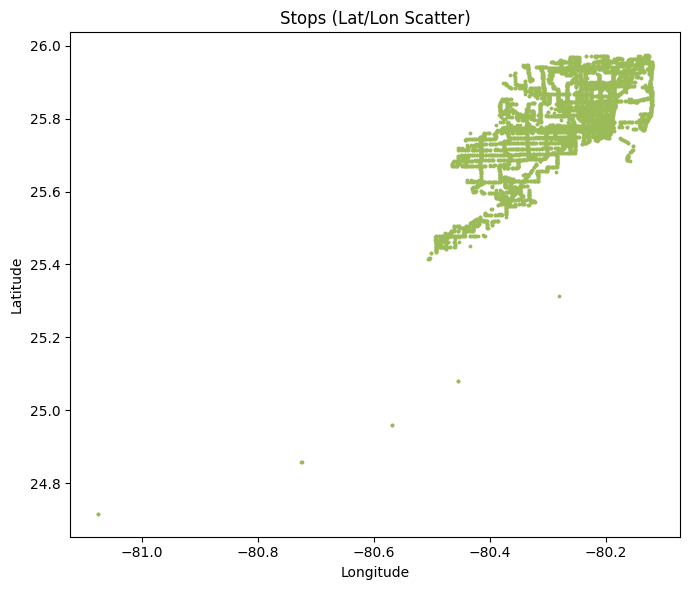


--- Parent/Child station structure ---
Stops with parent_station (children): 0
Unique parent_station ids referenced: 0

SHAPES EDA

--- Points per shape summary ---
Shapes counted: 299
Mean points: 362.94
Median points: 325.00
Min points: 40
Max points: 1472
90th percentile: 607.40


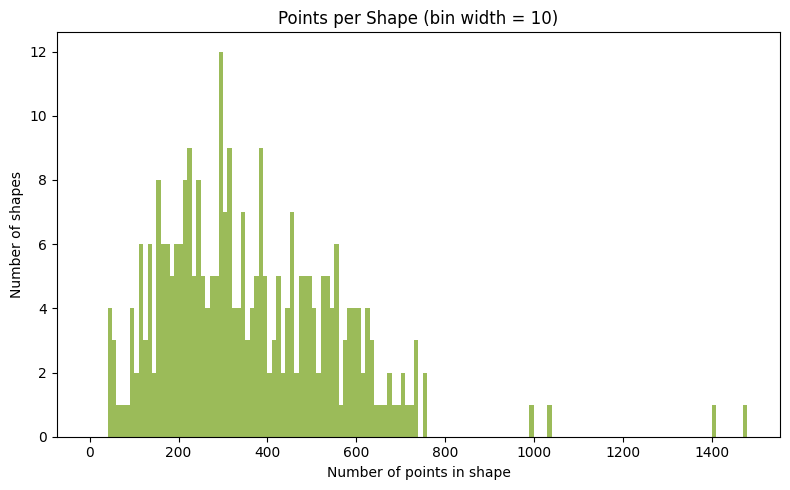

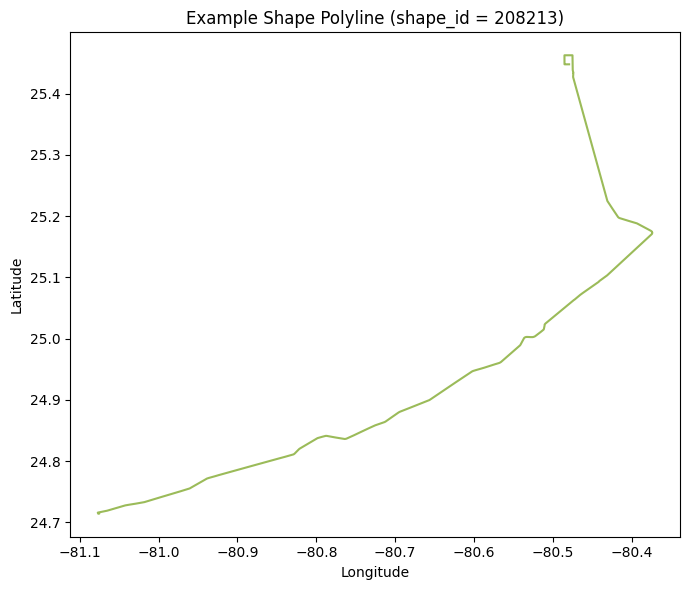


--- Shape length proxy (max shape_dist_traveled per shape) ---
Shapes with dist info: 299
Mean: 21.29
Median: 19.18
Min: 1.69
Max: 129.98
90th percentile: 33.94


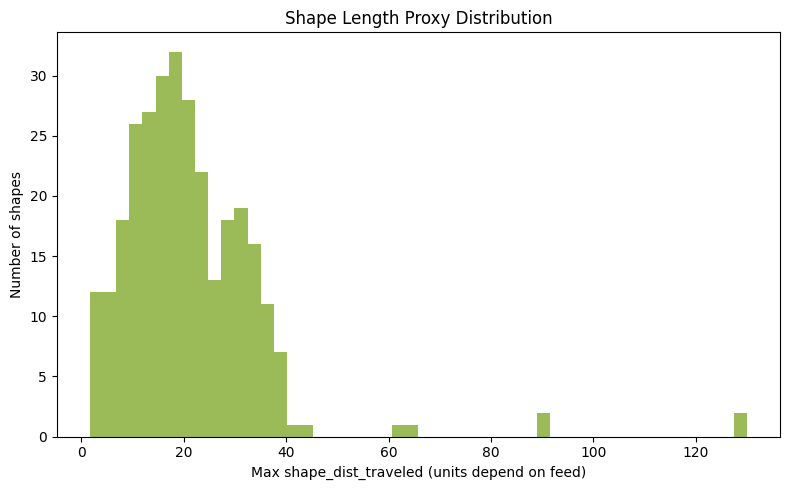


CALENDAR_DATES EDA

--- calendar_dates date coverage ---
Min date: NaT
Max date: NaT
Unique dates: 0

--- exception_type counts ---
exception_type
1    5
2    5


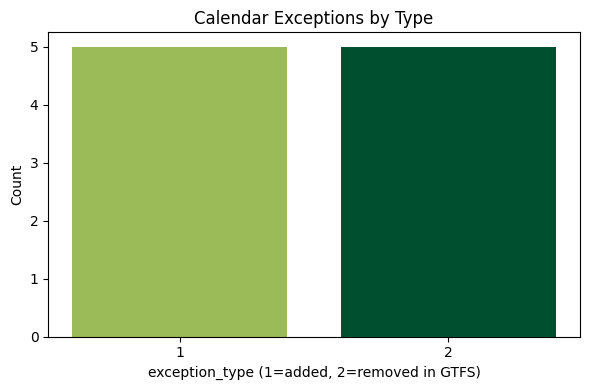


--- Top 10 service_ids by number of exceptions ---
service_id
6    3
8    3
1    2
3    2

Done.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Add numpy import for np.nan

new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Define new_colors here

def missing_table(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum()
    pct = (miss / len(df) * 100).round(2)
    return (
        pd.DataFrame({"missing": miss, "missing_%": pct})
        .sort_values("missing", ascending=False)
    )

print("Loading sheets...")
stops = pd.read_excel(FILE, sheet_name="stops", engine="openpyxl")
shapes = pd.read_excel(FILE, sheet_name="shapes", engine="openpyxl")
calendar_dates = pd.read_excel(FILE, sheet_name="calendar_dates", engine="openpyxl")

# -----------------------------
# 0) Basic counts table (new sheets only)
# -----------------------------
counts_new = pd.DataFrame([
    {"table": "stops", "rows": len(stops),
     "unique_stop_id": stops["stop_id"].nunique() if "stop_id" in stops else np.nan},
    {"table": "shapes", "rows": len(shapes),
     "unique_shape_id": shapes["shape_id"].nunique() if "shape_id" in shapes else np.nan},
    {"table": "calendar_dates", "rows": len(calendar_dates),
     "unique_service_id": calendar_dates["service_id"].nunique() if "service_id" in calendar_dates else np.nan},
])

print("\n=== Basic counts (new sheets) ===")
print(counts_new.to_string(index=False))

# -----------------------------
# 1) Missingness (data quality)
# -----------------------------
print("\n=== Missingness: stops (top 15) ===")
print(missing_table(stops).head(15).to_string())

print("\n=== Missingness: shapes (top 15) ===")
print(missing_table(shapes).head(15).to_string())

print("\n=== Missingness: calendar_dates (top 15) ===")
print(missing_table(calendar_dates).head(15).to_string())

# =========================================================
# STOPS EDA (most useful: geographic + categorical breakdown)
# =========================================================
print("\n====================")
print("STOPS EDA")
print("====================")

# Basic categorical distributions if present
for col in ["location_type", "wheelchair_boarding", "zone_id"]:
    if col in stops.columns:
        vc = stops[col].value_counts(dropna=False).head(20)
        print(f"\n--- {col} value counts (top 20) ---")
        print(vc.to_string())

# Lat/lon sanity + bounding box + simple scatter (if present)
if "stop_lat" in stops.columns and "stop_lon" in stops.columns:
    lat = pd.to_numeric(stops["stop_lat"], errors="coerce")
    lon = pd.to_numeric(stops["stop_lon"], errors="coerce")
    valid_geo = lat.notna() & lon.notna()

    print("\n--- Stops with valid lat/lon ---")
    print(f"Valid geo rows: {int(valid_geo.sum())} / {len(stops)}")

    if valid_geo.any():
        print("\n--- Lat/Lon bounds ---")
        print(f"Lat min/max: {lat[valid_geo].min():.6f} / {lat[valid_geo].max():.6f}")
        print(f"Lon min/max: {lon[valid_geo].min():.6f} / {lon[valid_geo].max():.6f}")

        plt.figure(figsize=(7, 6))
        plt.scatter(lon[valid_geo], lat[valid_geo], s=3, color=new_colors[0])
        plt.title("Stops (Lat/Lon Scatter)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        plt.show()

# Parent/child stations (if parent_station exists)
if "parent_station" in stops.columns and "stop_id" in stops.columns:
    n_child = stops["parent_station"].notna().sum()
    print("\n--- Parent/Child station structure ---")
    print(f"Stops with parent_station (children): {int(n_child)}")
    print(f"Unique parent_station ids referenced: {stops['parent_station'].nunique(dropna=True)}")

# =========================================================
# SHAPES EDA (most useful: points per shape + distance coverage)
# =========================================================
print("\n====================")
print("SHAPES EDA")
print("====================")

required_shape_cols = {"shape_id", "shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"}
if required_shape_cols.issubset(shapes.columns):
    pts_per_shape = shapes.groupby("shape_id").size()

    print("\n--- Points per shape summary ---")
    print(f"Shapes counted: {len(pts_per_shape)}")
    print(f"Mean points: {pts_per_shape.mean():.2f}")
    print(f"Median points: {pts_per_shape.median():.2f}")
    print(f"Min points: {pts_per_shape.min()}")
    print(f"Max points: {pts_per_shape.max()}")
    print(f"90th percentile: {pts_per_shape.quantile(0.90):.2f}")

    plt.figure(figsize=(8, 5))
    bins = range(0, int(pts_per_shape.max()) + 11, 10)
    plt.hist(pts_per_shape, bins=bins, color=new_colors[0])
    plt.title("Points per Shape (bin width = 10)")
    plt.xlabel("Number of points in shape")
    plt.ylabel("Number of shapes")
    plt.tight_layout()
    plt.show()

    # Plot one example shape (the one with the most points)
    example_shape_id = pts_per_shape.idxmax()
    ex = shapes[shapes["shape_id"] == example_shape_id].copy()
    ex["shape_pt_sequence"] = pd.to_numeric(ex["shape_pt_sequence"], errors="coerce")
    ex = ex.sort_values("shape_pt_sequence")

    ex_lat = pd.to_numeric(ex["shape_pt_lat"], errors="coerce")
    ex_lon = pd.to_numeric(ex["shape_pt_lon"], errors="coerce")
    ok = ex_lat.notna() & ex_lon.notna()

    if ok.any():
        plt.figure(figsize=(7, 6))
        plt.plot(ex_lon[ok], ex_lat[ok], color=new_colors[0])
        plt.title(f"Example Shape Polyline (shape_id = {example_shape_id})")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        plt.show()

# If shape_dist_traveled exists, summarize how long shapes are (approx)
if "shape_dist_traveled" in shapes.columns and "shape_id" in shapes.columns:
    dist = pd.to_numeric(shapes["shape_dist_traveled"], errors="coerce")
    # max dist per shape is a common proxy for total shape length
    shape_length = shapes.assign(_dist=dist).groupby("shape_id")["_dist"].max()

    shape_length = shape_length.dropna()
    if len(shape_length) > 0:
        print("\n--- Shape length proxy (max shape_dist_traveled per shape) ---")
        print(f"Shapes with dist info: {len(shape_length)}")
        print(f"Mean: {shape_length.mean():.2f}")
        print(f"Median: {shape_length.median():.2f}")
        print(f"Min: {shape_length.min():.2f}")
        print(f"Max: {shape_length.max():.2f}")
        print(f"90th percentile: {shape_length.quantile(0.90):.2f}")

        plt.figure(figsize=(8, 5))
        plt.hist(shape_length, bins=50, color=new_colors[0])
        plt.title("Shape Length Proxy Distribution")
        plt.xlabel("Max shape_dist_traveled (units depend on feed)")
        plt.ylabel("Number of shapes")
        plt.tight_layout()
        plt.show()

# =========================================================
# CALENDAR_DATES EDA (most useful: exceptions by type + date range)
# =========================================================
print("\n====================")
print("CALENDAR_DATES EDA")
print("====================")

if "date" in calendar_dates.columns:
    # GTFS calendar_dates.date is usually YYYYMMDD
    dates = pd.to_datetime(calendar_dates["date"].astype(str), format="%Y%m%d", errors="coerce")
    print("\n--- calendar_dates date coverage ---")
    print(f"Min date: {dates.min()}")
    print(f"Max date: {dates.max()}")
    print(f"Unique dates: {dates.nunique()}")

if "exception_type" in calendar_dates.columns:
    ex = calendar_dates["exception_type"].value_counts(dropna=False)
    print("\n--- exception_type counts ---")
    print(ex.to_string())

    plt.figure(figsize=(6, 4))
    plt.bar(ex.index.astype(str), ex.values, color=new_colors)
    plt.title("Calendar Exceptions by Type")
    plt.xlabel("exception_type (1=added, 2=removed in GTFS)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Top services with the most exceptions
if "service_id" in calendar_dates.columns:
    top_services = calendar_dates["service_id"].value_counts().head(10)
    print("\n--- Top 10 service_ids by number of exceptions ---")
    print(top_services.to_string())

print("\nDone.")

In [ ]:
# Load routes and stops dataframes
routes = pd.read_excel(FILE, sheet_name="routes", engine="openpyxl")
stops = pd.read_excel(FILE, sheet_name="stops", engine="openpyxl")

# 1. Create named_routes DataFrame
named_routes = routes[['route_id', 'route_short_name', 'route_long_name']].drop_duplicates(subset=['route_id'])

# 2. & 3. Create route_label with priority: short_name > long_name > route_id, and ensure string type
# Start with route_id as default label (as string)
named_routes['route_label'] = named_routes['route_id'].astype(str)

# Check for valid route_short_name (not NaN and not empty string)
short_name_valid = named_routes['route_short_name'].notna() & (named_routes['route_short_name'].astype(str) != '')
named_routes.loc[short_name_valid, 'route_label'] = named_routes.loc[short_name_valid, 'route_short_name'].astype(str)

# Check for valid route_long_name (not NaN and not empty string) only if short_name was not valid
long_name_valid = named_routes['route_long_name'].notna() & (named_routes['route_long_name'].astype(str) != '')
named_routes.loc[~short_name_valid & long_name_valid, 'route_label'] = named_routes.loc[~short_name_valid & long_name_valid, 'route_long_name'].astype(str)

print("named_routes DataFrame created and duplicates removed.")
print(named_routes.head())

# 4. Create named_stops DataFrame
named_stops = stops[['stop_id', 'stop_name']].drop_duplicates(subset=['stop_id'])

# 5. Fill missing stop_name with stop_id (as string)
named_stops['stop_name'] = named_stops['stop_name'].fillna(named_stops['stop_id'].astype(str))

print("\nnamed_stops DataFrame created and missing stop_names filled.")
print(named_stops.head())

named_routes DataFrame created and duplicates removed.
   route_id route_short_name                      route_long_name route_label
0     30398                2      DOWNTOWN- NE 84 ST VIA NW 2 AVE           2
1     30399                3     AVENTURA-DOWNTOWN VIA BISC.BLVD.           3
2     30400                7  DOWNTOWN-DOLPH MALL/AIRPORT VIA 7ST           7
3     30401                8  BRICKELL-107AV/WSTCHSTR VIA SW 8 ST           8
4     30402                9       AVENTURA-DOWNTOWN VIA NE 2 AVE           9

named_stops DataFrame created and missing stop_names filled.
   stop_id                           stop_name
0        1         SW 114 AVE & QUAIL ROOST DR
1        2      SW 211 ST @ OP S DADE GOVT CTR
2        4  TRANSITWAY & CORAL REEF DR STATION
3        5      TRANSITWAY & HOWARD DR STATION
4        6    DADELAND SOUTH METRORAIL STATION


**Merge the 'trips' DataFrame with the 'named_routes' lookup table to add a 'route_label' column, combining 'route_short_name' and 'route_long_name' for better readability**


In [ ]:
trips_enriched = pd.merge(trips, named_routes[['route_id', 'route_label']], on='route_id', how='left')

print("Enriched trips DataFrame created.")
print(trips_enriched.head())

Enriched trips DataFrame created.
   route_id  service_id  trip_id trip_headsign  trip_short_name  direction_id  \
0     14456          11  4828771      DOWNTOWN              NaN             0   
1     14456          11  4828981      DOWNTOWN              NaN             0   
2     14456          11  4828772      DOWNTOWN              NaN             0   
3     14456          11  4828982      DOWNTOWN              NaN             0   
4     14456          11  4828773      DOWNTOWN              NaN             0   

   block_id  shape_id  wheelchair_accessible  bikes_allowed route_label  
0   1403221    123745                      2              2         MMO  
1   1403223    123746                      2              2         MMO  
2   1403225    123745                      2              2         MMO  
3   1403220    123746                      2              2         MMO  
4   1403218    123745                      2              2         MMO  


**Merge the 'stop_times' DataFrame with the 'named_stops' lookup table to add a 'stop_name' column**

In [ ]:
FILE = '/content/transit_data.xlsx'
stop_times = pd.read_excel(FILE, sheet_name="stop_times", engine="openpyxl")

stop_times_enriched = pd.merge(stop_times, named_stops[['stop_id', 'stop_name']], on='stop_id', how='left')

print("Enriched stop_times DataFrame created.")
print(stop_times_enriched.head())

Enriched stop_times DataFrame created.
   trip_id arrival_time departure_time  stop_id  stop_sequence  stop_headsign  \
0  4828771     05:32:00       05:32:00      795              1            NaN   
1  4828771     05:33:00       05:33:00      796              2            NaN   
2  4828771     05:34:00       05:34:00      797              3            NaN   
3  4828771     05:35:00       05:35:00      798              4            NaN   
4  4828771     05:36:00       05:36:00      799              5            NaN   

   pickup_type  drop_off_type  shape_dist_traveled  timepoint  \
0            0              0                  NaN          1   
1            0              0               0.5206          1   
2            0              0               1.1206          1   
3            0              0               1.4817          1   
4            0              0               1.7449          1   

                                  stop_name  
0           SCHOOL BOARD METROMOVER S

**Route type distribution**

In [ ]:
route_type_lookup = {
    0: 'Tram, Streetcar, Light Rail',
    1: 'Subway, Metro',
    2: 'Rail',
    3: 'Bus',
    4: 'Ferry',
    5: 'Cable Car',
    6: 'Gondola, Suspended Cable Car',
    7: 'Funicular'
}

print("route_type_lookup dictionary created:")
print(route_type_lookup)

route_type_lookup dictionary created:
{0: 'Tram, Streetcar, Light Rail', 1: 'Subway, Metro', 2: 'Rail', 3: 'Bus', 4: 'Ferry', 5: 'Cable Car', 6: 'Gondola, Suspended Cable Car', 7: 'Funicular'}


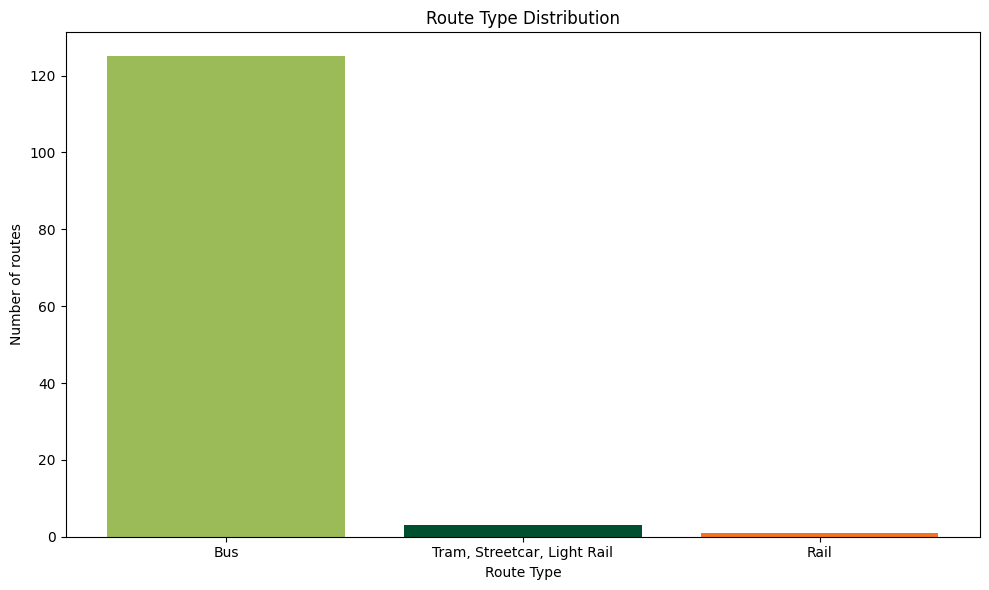

In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Added new_colors
routes = pd.read_excel(FILE, sheet_name="routes", engine="openpyxl")

# Create a copy to avoid SettingWithCopyWarning
routes_copy = routes.copy()

# Map route_type to descriptive names
routes_copy['route_type_name'] = routes_copy['route_type'].map(route_type_lookup)

# Calculate the value counts of this new route_type_name column
route_type_counts = routes_copy['route_type_name'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(route_type_counts.index, route_type_counts.values, color=new_colors)

# Add title and labels
plt.title('Route Type Distribution')
plt.xlabel('Route Type')
plt.ylabel('Number of routes')

# Ensure layout is tight
plt.tight_layout()

# Display the plot
plt.show()

**Service added/removed**

In [ ]:
exception_type_lookup = {
    1: 'Service Added',
    2: 'Service Removed'
}

print("exception_type_lookup dictionary created:")
print(exception_type_lookup)

exception_type_lookup dictionary created:
{1: 'Service Added', 2: 'Service Removed'}


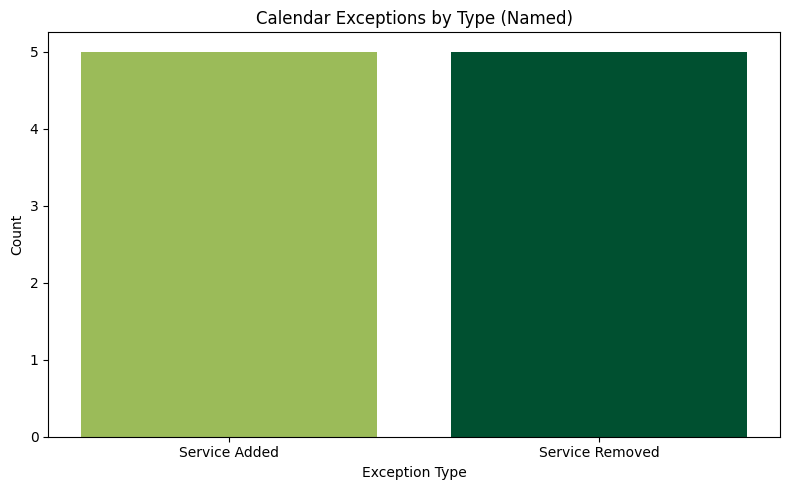

In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Added new_colors
calendar_dates = pd.read_excel(FILE, sheet_name="calendar_dates", engine="openpyxl")

# Map exception_type to descriptive names
calendar_dates['exception_type_name'] = calendar_dates['exception_type'].map(exception_type_lookup)

# Calculate the value counts of this new exception_type_name column
exception_type_counts = calendar_dates['exception_type_name'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(exception_type_counts.index, exception_type_counts.values, color=new_colors)

# Add title and labels
plt.title('Calendar Exceptions by Type (Named)')
plt.xlabel('Exception Type')
plt.ylabel('Count')

# Ensure layout is tight
plt.tight_layout()

# Display the plot
plt.show()

**Trips by direction**

In [ ]:
direction_lookup = {
    0: 'Outbound',
    1: 'Inbound'
}

print("direction_lookup dictionary created:")
print(direction_lookup)

direction_lookup dictionary created:
{0: 'Outbound', 1: 'Inbound'}


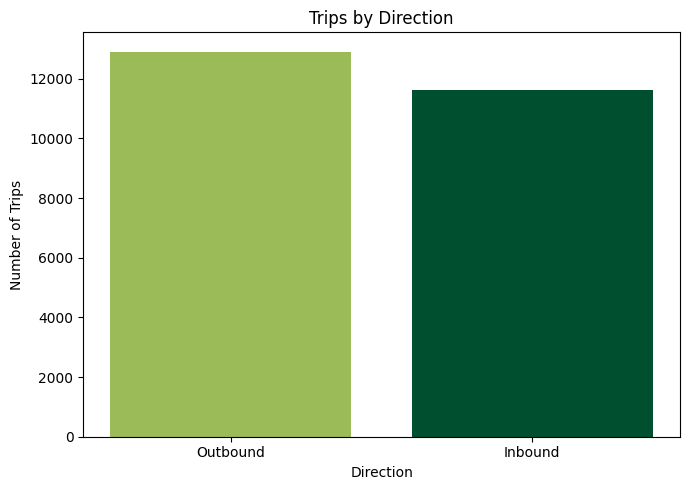

Trips by Direction chart displayed.


In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Added new_colors
import pandas as pd
import matplotlib.pyplot as plt

FILE = '/content/transit_data.xlsx'
trips = pd.read_excel(FILE, sheet_name="trips", engine="openpyxl")

# Map direction_id to descriptive names
trips['direction_name'] = trips['direction_id'].map(direction_lookup)

# Calculate the value counts of this new direction_name column
direction_counts = trips['direction_name'].value_counts()

# Create a bar plot
plt.figure(figsize=(7, 5))
plt.bar(direction_counts.index, direction_counts.values, color=new_colors)

# Add title and labels
plt.title('Trips by Direction')
plt.xlabel('Direction')
plt.ylabel('Number of Trips')

# Ensure layout is tight
plt.tight_layout()

# Display the plot
plt.show()

print("Trips by Direction chart displayed.")

**Reasoning**:
The previous subtask of visualizing the 'direction_id' distribution is complete. Now, to continue with the main task, I need to visualize the distribution of 'wheelchair_boarding' in the `stops` DataFrame using descriptive names. The first step is to create a lookup dictionary for 'wheelchair_boarding' as specified.



**Wheelchair accessibility**

In [ ]:
wheelchair_boarding_lookup = {
    0: 'No Info',
    1: 'Accessible',
    2: 'Not Accessible'
}

print("wheelchair_boarding_lookup dictionary created:")
print(wheelchair_boarding_lookup)

wheelchair_boarding_lookup dictionary created:
{0: 'No Info', 1: 'Accessible', 2: 'Not Accessible'}


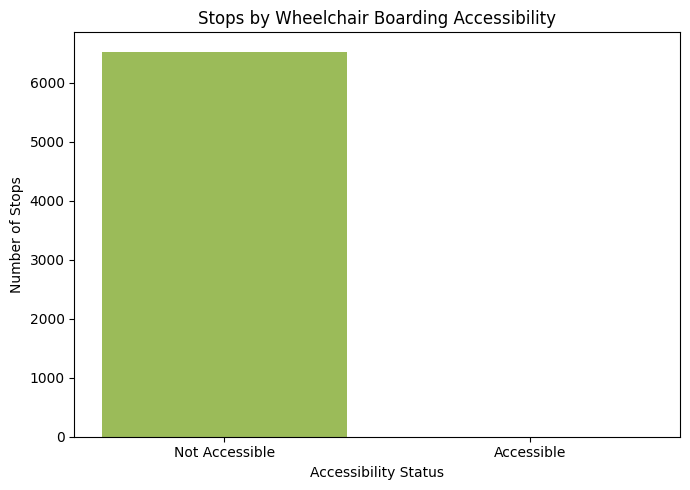

Stops by Wheelchair Boarding Accessibility chart displayed.


In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Added new_colors
FILE = '/content/transit_data.xlsx'
stops = pd.read_excel(FILE, sheet_name="stops", engine="openpyxl")

# Map wheelchair_boarding to descriptive names
stops['wheelchair_boarding_name'] = stops['wheelchair_boarding'].map(wheelchair_boarding_lookup)

# Calculate the value counts of this new wheelchair_boarding_name column
wheelchair_counts = stops['wheelchair_boarding_name'].value_counts()

# Create a bar plot
plt.figure(figsize=(7, 5))
plt.bar(wheelchair_counts.index, wheelchair_counts.values, color=new_colors)

# Add title and labels
plt.title('Stops by Wheelchair Boarding Accessibility')
plt.xlabel('Accessibility Status')
plt.ylabel('Number of Stops')

# Ensure layout is tight
plt.tight_layout()

# Display the plot
plt.show()

print("Stops by Wheelchair Boarding Accessibility chart displayed.")

In [ ]:
accessible_stops = stops[stops['wheelchair_boarding_name'] == 'Accessible']

print("Accessible stops DataFrame created.")
print(accessible_stops.head())

Accessible stops DataFrame created.
     stop_id stop_code              stop_name stop_desc   stop_lat   stop_lon  \
476     1027  152S137N  SW 137 AV @ SW 152 ST       NaN  25.625117 -80.414336   

     zone_id  stop_url  location_type  parent_station  stop_timezone  \
476      NaN       NaN            NaN             NaN            NaN   

     wheelchair_boarding wheelchair_boarding_name  
476                    1               Accessible  


In [ ]:
print("Full details of accessible stop(s):")
print(accessible_stops.to_string())

Full details of accessible stop(s):
     stop_id stop_code              stop_name stop_desc   stop_lat   stop_lon  zone_id  stop_url  location_type  parent_station  stop_timezone  wheelchair_boarding wheelchair_boarding_name
476     1027  152S137N  SW 137 AV @ SW 152 ST       NaN  25.625117 -80.414336      NaN       NaN            NaN             NaN            NaN                    1               Accessible


## Summary of Wheelchair Accessibility Findings

Based on the analysis of the `stops` DataFrame and the `wheelchair_boarding` status:

*   A total of **1 stop** was identified as 'Accessible' (where `wheelchair_boarding` is 1).
*   The specific accessible stop has `stop_id` **1027** and `stop_name` 'SW 137 AV @ SW 152 ST'.
*   In contrast, **6529 stops** were marked as 'Not Accessible' (where `wheelchair_boarding` is 2).
*   There were **0 stops** with 'No Info' regarding wheelchair boarding, indicating that all stops had a defined status.

- The transit system exhibits a critical lack of wheelchair accessibility, with less than 0.02% of its stops being accessible. This poses a significant barrier for individuals with mobility impairments.

**Distribution of trips by hour**

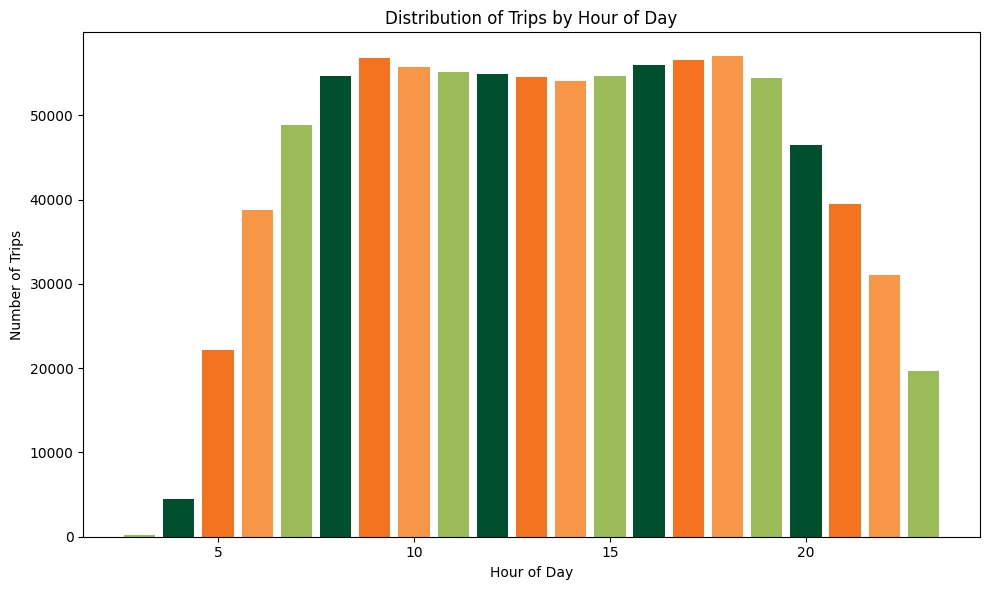

Extracted 'arrival_hour' and added to stop_times_enriched DataFrame. Displayed distribution chart.


In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Added new_colors

named_stops = stops[['stop_id', 'stop_name']].drop_duplicates(subset=['stop_id'])
named_stops['stop_name'] = named_stops['stop_name'].fillna(named_stops['stop_id'].astype(str))

# Load stop_times and create stop_times_enriched
stop_times = pd.read_excel(FILE, sheet_name="stop_times", engine="openpyxl")
stop_times_enriched = pd.merge(stop_times, named_stops[['stop_id', 'stop_name']], on='stop_id', how='left')

# 1. Extract the hour component from the 'arrival_time' column
stop_times_enriched['arrival_hour'] = pd.to_datetime(stop_times_enriched['arrival_time'], format='%H:%M:%S', errors='coerce').dt.hour

# 2. Calculate the count of occurrences for each 'arrival_hour'
hour_counts = stop_times_enriched['arrival_hour'].value_counts().sort_index()

# 3. Create a bar chart to visualize this distribution
plt.figure(figsize=(10, 6))
plt.bar(hour_counts.index, hour_counts.values, color=new_colors)

# Add title and labels
plt.title('Distribution of Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')

# Ensure layout is tight
plt.tight_layout()

# 4. Display the plot
plt.show()

print("Extracted 'arrival_hour' and added to stop_times_enriched DataFrame. Displayed distribution chart.")

In [ ]:
stops_routes_merged = pd.merge(stop_times_enriched, trips[['trip_id', 'route_id']], on='trip_id', how='left')

print("Merged stop_times_enriched with trips (for route_id).")
print(stops_routes_merged.head())

Merged stop_times_enriched with trips (for route_id).
   trip_id arrival_time departure_time  stop_id  stop_sequence  stop_headsign  \
0  4828771     05:32:00       05:32:00      795              1            NaN   
1  4828771     05:33:00       05:33:00      796              2            NaN   
2  4828771     05:34:00       05:34:00      797              3            NaN   
3  4828771     05:35:00       05:35:00      798              4            NaN   
4  4828771     05:36:00       05:36:00      799              5            NaN   

   pickup_type  drop_off_type  shape_dist_traveled  timepoint  \
0            0              0                  NaN          1   
1            0              0               0.5206          1   
2            0              0               1.1206          1   
3            0              0               1.4817          1   
4            0              0               1.7449          1   

                                  stop_name  arrival_hour  route_id 

**Unique routes per stop**

In [ ]:
routes_per_stop = stops_routes_merged.groupby('stop_id')['route_id'].nunique()

print("Number of unique routes serving each stop calculated.")
print(routes_per_stop.head())

Number of unique routes serving each stop calculated.
stop_id
1    1
2    6
4    1
5    1
6    5
Name: route_id, dtype: int64


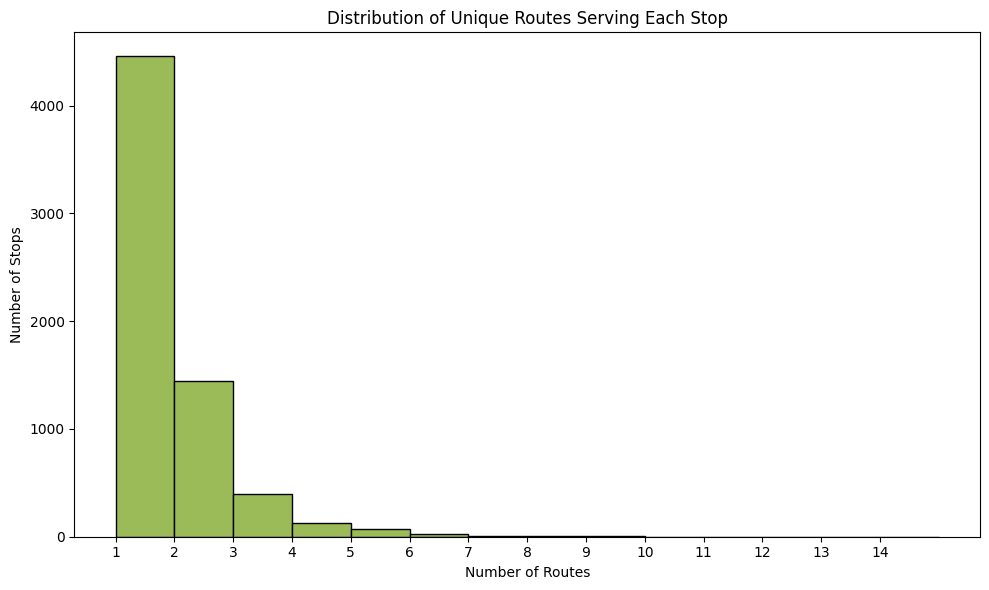

Histogram of unique routes serving each stop displayed.


In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Added new_colors
plt.figure(figsize=(10, 6))
plt.hist(routes_per_stop, bins=range(1, routes_per_stop.max() + 2), edgecolor='black', color=new_colors[0])

plt.title('Distribution of Unique Routes Serving Each Stop')
plt.xlabel('Number of Routes')
plt.ylabel('Number of Stops')

plt.xticks(range(1, routes_per_stop.max() + 1))
plt.tight_layout()
plt.show()

print("Histogram of unique routes serving each stop displayed.")



### Data Analysis Key Findings
*   **Trips by Hour of Day**: The distribution of trips by hour shows a clear bimodal pattern, with two prominent peaks. The first peak occurs around **8 AM**, indicating morning rush hour, and the second, larger peak occurs around **5 PM** to **6 PM**, indicating evening rush hour. Trip activity is significantly lower during late-night and early-morning hours (e.g., from 1 AM to 4 AM).
*   **Stops by Number of Serving Routes**:
    *   A significant number of stops are served by a single route.
    *   Many stops are served by 2 or 3 routes, suggesting common intersection points.
    *   A smaller proportion of stops serve a higher number of routes, with some stops serving as many as 6 or more unique routes, highlighting them as key transfer points or hubs within the transit system.

### Insights or Next Steps
*   **Insight**: The transit system effectively caters to typical commuting patterns, with peak service aligning with morning and evening rush hours. The varying route connectivity among stops suggests a network with both local access points and strategic transfer hubs.
*   **Next Steps**: Further analysis could investigate the specific routes serving the busiest stops to understand their coverage and potential for optimization, as well as examine rider demand during off-peak hours to determine if service adjustments could improve efficiency or attract more riders.


## Dataset Features Overview

This section lists all the features (columns) available in the various DataFrames used throughout the analysis, including original and newly derived columns.

### Original DataFrames and their Columns:

**1. `routes` DataFrame:**
```
route_id
agency_id
route_short_name
route_long_name
route_desc
route_type
route_url
route_color
route_text_color
```

**2. `trips` DataFrame:**
```
route_id
service_id
trip_id
trip_headsign
trip_short_name
direction_id
block_id
shape_id
wheelchair_accessible
bikes_allowed
```

**3. `stop_times` DataFrame:**
```
trip_id
arrival_time
departure_time
stop_id
stop_sequence
stop_headsign
pickup_type
drop_off_type
shape_dist_traveled
timepoint
```

**4. `stops` DataFrame:**
```
stop_id
stop_code
stop_name
stop_desc
stop_lat
stop_lon
zone_id
stop_url
location_type
parent_station
stop_timezone
wheelchair_boarding
```

**5. `calendar` DataFrame:**
```
service_id
monday
tuesday
wednesday
thursday
friday
saturday
sunday
start_date
end_date
```

**6. `shapes` DataFrame:**
```
shape_id
shape_pt_lat
shape_pt_lon
shape_pt_sequence
shape_dist_traveled
```

**7. `calendar_dates` DataFrame:**
```
service_id
date
exception_type
```

### Newly Created/Enriched Features during Analysis:

**1. `named_routes` DataFrame:**
   - `route_label`: A descriptive label for each route, prioritizing `route_short_name` over `route_long_name` and falling back to `route_id`.

**2. `named_stops` DataFrame:**
   - `stop_name`: Original `stop_name`, with missing values filled using `stop_id`.

**3. `trips_enriched` DataFrame:**
   - Includes all original `trips` columns plus `route_label` (from `named_routes`).

**4. `stop_times_enriched` DataFrame:**
   - Includes all original `stop_times` columns plus `stop_name` (from `named_stops`).
   - `arrival_hour`: Extracted hour component from `arrival_time`.

**5. `stops_routes_merged` DataFrame:**
   - Combination of `stop_times_enriched` and `trips` columns, linking `stop_id` to `route_id`.

**6. `routes_per_stop` Series:**
   - A Series where the index is `stop_id` and the values represent the count of unique `route_id`s serving that stop.

**7. `accessible_stops` DataFrame:**
   - A filtered version of the `stops` DataFrame, containing only stops identified as 'Accessible'.

**8. Mapped Categorical Variable Names:**
   - `route_type_name`: Descriptive names for `route_type` (e.g., 'Bus', 'Rail').
   - `exception_type_name`: Descriptive names for `exception_type` (e.g., 'Service Added', 'Service Removed').
   - `direction_name`: Descriptive names for `direction_id` (e.g., 'Outbound', 'Inbound').
   - `wheelchair_boarding_name`: Descriptive names for `wheelchair_boarding` (e.g., 'Accessible', 'Not Accessible', 'No Info').

**Distribution of trips per route**

In [ ]:
trips = pd.read_excel(FILE, sheet_name="trips", engine="openpyxl")
trips_per_route = trips.groupby('route_id')['trip_id'].count()

print("Trips per route calculated:")
print(trips_per_route.head())

Trips per route calculated:
route_id
14456    2384
14457    1877
14458    2442
23885      28
23886      26
Name: trip_id, dtype: int64


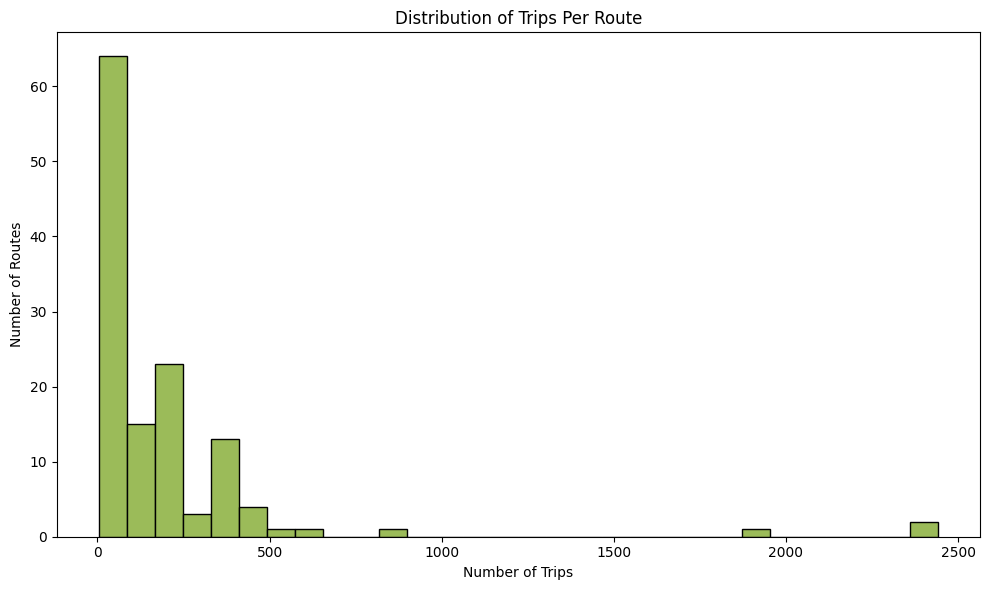

In [ ]:
new_colors = ['#9bbb59', '#005030', '#f47321', '#f79646'] # Added new_colors
plt.figure(figsize=(10, 6))
plt.hist(trips_per_route, bins=30, edgecolor='black', color=new_colors[0])
plt.title('Distribution of Trips Per Route')
plt.xlabel('Number of Trips')
plt.ylabel('Number of Routes')
plt.tight_layout()
plt.show()

In [ ]:
def gini(arr):
    """
    Calculate the Gini coefficient of a non-negative array.
    A Gini coefficient of 0 expresses perfect equality,
    while a coefficient of 1 expresses maximal inequality.
    """
    # Values cannot be negative
    arr = arr.flatten()
    if np.amin(arr) < 0:
        raise ValueError("Array must contain only non-negative values.")
    # All values are 0
    if np.all(arr == 0):
        return 0.0
    # Values must be sorted first
    arr = np.sort(arr)
    # Index per array element
    index = np.arange(1, arr.shape[0] + 1)
    # N
    n = arr.shape[0]
    # Gini calculation
    return ((np.sum((2 * index - n - 1) * arr)) / (n * np.sum(arr)))

gini_coefficient = gini(trips_per_route.values)

print(f"Gini coefficient for trip distribution per route: {gini_coefficient:.4f}")

Gini coefficient for trip distribution per route: 0.6330


### Summary of Trip Distribution Across Routes

Based on the analysis of `trips_per_route` and the calculated Gini coefficient:

*   **Distribution Visualization (Histogram)**:
    *   The histogram clearly shows a highly skewed distribution, with a large number of routes having a relatively low number of trips.
    *   A smaller number of routes account for a disproportionately high number of trips, indicating that a few routes are significantly busier than the majority.
    *   The distribution is concentrated towards the lower end, with a long tail extending to higher trip counts, confirming a significant disparity in service frequency.

*   **Gini Coefficient (0.6330)**:
    *   A Gini coefficient of 0.6330 is relatively high, indicating a substantial level of inequality in the distribution of trips across different routes within the transit network.
    *   A value closer to 0 would suggest more equal distribution, while a value closer to 1 would indicate maximal inequality. The calculated value suggests that a significant portion of the total trips are concentrated on a limited number of routes.

### Overall Insight:

Both the visual representation and the Gini coefficient point to a transit network where service is not evenly distributed. A few 'trunk' or popular routes carry a large share of the total trips, while many other routes have much lower service frequencies. This pattern is common in transit systems, reflecting varying demand, but a high Gini coefficient might also indicate areas for optimization or re-evaluation of service allocation, potentially identifying underserved areas or underutilized routes.

## Summary:

### Q&A
*   **How is the distribution of trips across different routes analyzed?**
    The distribution was analyzed by calculating the number of trips for each unique route, visualizing this data with a histogram, and quantifying the inequality using the Gini coefficient.
*   **What does the distribution visualization reveal?**
    The histogram shows a highly skewed distribution where a large number of routes have a relatively low number of trips, while a smaller number of routes account for a disproportionately high number of trips. This indicates a significant disparity in service frequency, concentrated towards the lower end with a long tail extending to higher trip counts.
*   **What does the Gini coefficient indicate about the equality of service distribution?**
    A Gini coefficient of 0.6330 indicates a substantial level of inequality in the distribution of trips across routes, suggesting that service is not evenly distributed within the transit network.

### Data Analysis Key Findings
*   The distribution of trips per route is highly skewed, with many routes having a low number of trips and a few routes carrying a significantly higher number of trips.
*   The Gini coefficient for trip distribution across routes is approximately 0.6330, which signifies a substantial level of inequality in service distribution.

### Insights or Next Steps
*   The transit network's service is not evenly distributed, with a few popular routes handling a large share of trips while many others have lower frequencies.
*   The high Gini coefficient suggests potential areas for optimizing or re-evaluating service allocation to address potentially underserved areas or underutilized routes within the network.
